In [1]:
import os
import numpy as np
from skimage.io import imread

def get_texture2D_iter(folder, npx=128, npy=128, batch_size=64, 
                       mirrorlr=False, mirrorud=False, intra=False, n_channel=1):
    HW1    = npx
    HW2    = npy
    imTex = []
    files = os.listdir(folder)
    files.sort()
    for f in files:
        name = folder + f
    #try:
        img = imread(name)
        img = np.invert(img) # invert black and white
        img = img/255.0
        imTex += [img]
            
    #except:
    #    print("Image ", name, " failed to load!")
    
    # Load eigenvectors for gaussian intrafacies field.
    seigvecs = np.load('keigvecsh1v02.npy') 
    ceigvecs = np.load('keigvecsh1v025.npy')
    seigvals = np.load('keigvalsh1v02.npy')
    ceigvals = np.load('keigvalsh1v025.npy')
    # set parameters for intrafacies log-normal distributions
    cmux = 0.05 # minimum mean velocity in clay
    csigmax = 0.02
    cmu = np.log(cmux**2/np.sqrt(cmux**2+csigmax**2))
    csigma = np.log(1+csigmax**2/cmux**2)
    sf = (cmux+0.07+0.04)+2*csigmax # scaling factor (i.e. scale to interval [0,1])

    while True:
        data=np.zeros((batch_size,n_channel,npx,npy))
        indimg=np.zeros((batch_size),dtype=int)
        for i in range(batch_size):
            ir = np.random.randint(len(imTex))
            #intra=np.random.randint(2) # force intrafacies to randomly present
            imgBig = imTex[ir]
            if HW1 < imgBig.shape[0] and HW2 < imgBig.shape[1]:
                h = np.random.randint(imgBig.shape[0] - HW1)
                w = np.random.randint(imgBig.shape[1] - HW2)
                img = imgBig[h:h + HW1, w:w + HW2]
            else:                                               
                img = imgBig
            if mirrorlr:
                img = np.fliplr(img)
            if mirrorud:
                img = np.flipud(img)
                
            if intra: # generate from Karhunen-Loeve expansion (or PCA) of Gaussian process
                ncs = 150
                sshift = 0.09 #sshift = 0.07+0.04*np.random.rand()
                sstnorm = np.random.randn(ncs)
                sgen = (np.sqrt(seigvals[:ncs])*sstnorm[:ncs]).T@seigvecs[:,:ncs].T
                sgen = sgen.reshape(npx+1,npy+1)
                sgen = sgen[:npx,:npy]
                sgen = np.exp(cmu+csigma*sgen)
                #sgen = 0.07+sgen # displace origin to 0.07
                sgen = sgen+sshift
                ncc = 150
                cshift = 0.02 #cshift = 0.04*np.random.rand()
                cstnorm = np.random.randn(ncc)
                cgen = (np.sqrt(ceigvals[:ncc])*cstnorm[:ncc]).T@ceigvecs[:,:ncc].T
                cgen = cgen.reshape(npx+1,npy+1)
                cgen = cgen[:npx,:npy]
                cgen = np.exp(cmu+csigma*cgen)
                cgen = cgen+cshift
                sand = img>0.5
                clay = img<=0.5
                img = sgen/sf*sand # the upper bound is just smux+2*ssigma
                img = img + cgen/sf*clay
            else:
                sshift = 0.14 #sshift = 0.12+0.04*np.random.rand()
                cshift = 0.07 #cshift = 0.04+0.04*np.random.rand()
                sand = img>0.5
                clay = img<=0.5
                img = sshift/sf*sand # the upper bound is just smux+2*ssigma
                img = img + cshift/sf*clay
            data[i] = img
            indimg[i] = ir

        yield data#,indimg

In [2]:
texture_dir = "/home/jorge/Documents/PhD_proj3/tilarge2_tilargesheet2/"
npx = 129
npy = 65
batch_size = 100
nc = 1
data_iter   = get_texture2D_iter(texture_dir, npx=npx, npy=npy, mirrorlr=True, mirrorud=True,
                                 batch_size=batch_size, intra=True, n_channel=nc)

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
#from facies_dataset import Facies_Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time

In [10]:
seed = 2
dimz = 40
alpha = 1.0
beta = 1000

In [11]:
torch.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
#train_loader = data_iter
#train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [12]:
torch.cuda.is_available()

True

In [13]:
# Fixed input for debugging
fixed_x = next(iter(data_iter))
fixed_x.shape

(100, 1, 129, 65)

(array([ 444., 1495., 1890., 1383.,  643.,  260.,   37.,    0.,    0.,
           0.,    0.,    0.,    0.,   11.,   31.,  178.,  725.,  763.,
         399.,  126.]),
 array([0.27364983, 0.29783271, 0.32201559, 0.34619846, 0.37038134,
        0.39456422, 0.4187471 , 0.44292997, 0.46711285, 0.49129573,
        0.5154786 , 0.53966148, 0.56384436, 0.58802723, 0.61221011,
        0.63639299, 0.66057587, 0.68475874, 0.70894162, 0.7331245 ,
        0.75730737]),
 <a list of 20 Patch objects>)

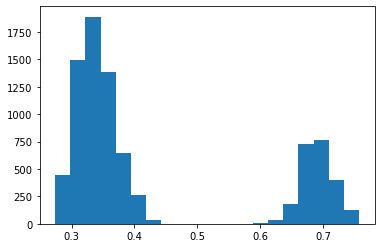

In [14]:
plt.hist(fixed_x[0,0,:,:].flatten(),bins=20)

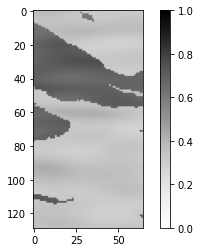

In [15]:
fig,ax = plt.subplots()
cb = ax.imshow(fixed_x[0,0,:,:],'Greys',vmin=0.0,vmax=1.0)
fig.colorbar(cb)

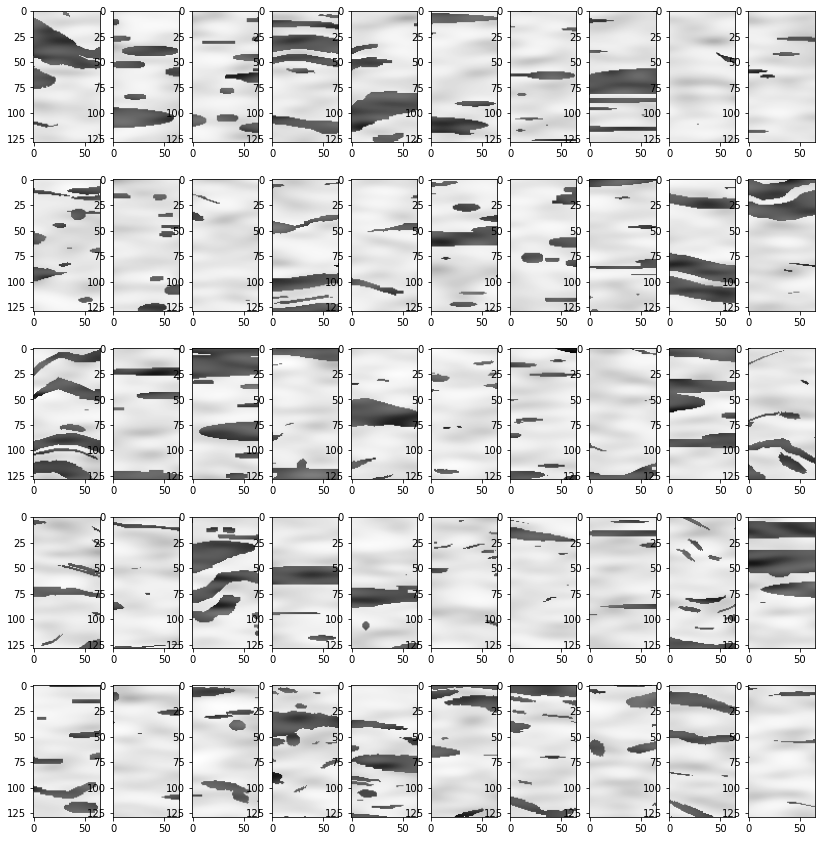

In [16]:
fig, ax = plt.subplots(5,10,figsize=(14,15))
ax = ax.ravel()
#vmax,vmin = 1.0,0.0
vmax,vmin = np.max(fixed_x),np.min(fixed_x)
for i in range(len(ax)):
    ax[i].imshow(fixed_x[i,0,:,:],'Greys',vmin=vmin,vmax=vmax)

In [17]:
print(np.max(fixed_x))
print(np.min(fixed_x))

0.847613783146581
0.22219127892213017


In [18]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 6, 2)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=12*256, z_dim=dimz):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=5, stride=2, bias=False),
            nn.InstanceNorm2d(32), #nn.BatchNorm2d(32,momentum=0.01),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, bias=False),
            nn.InstanceNorm2d(64), #nn.BatchNorm2d(64,momentum=0.01),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(128), #nn.BatchNorm2d(128,momentum=0.01),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(256), #nn.BatchNorm2d(256,momentum=0.01),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(12*256,512),
            nn.LeakyReLU()
        )
        
        self.fc1 = nn.Linear(512, z_dim)
        self.fc2 = nn.Linear(512, z_dim)
        self.fc3 = nn.Linear(z_dim, 512)
        
        self.decoder = nn.Sequential(
            nn.Linear(512,12*256),
            nn.LeakyReLU(),
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(128), #nn.BatchNorm2d(128,momentum=0.01),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(64), #nn.BatchNorm2d(64,momentum=0.01),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, bias=False),
            nn.InstanceNorm2d(32), #nn.BatchNorm2d(32,momentum=0.01),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=2, bias=False),
            nn.ReLU()
            #nn.Sigmoid(),
            #nn.Tanhshrink()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=device)
        z = mu + std * esp * alpha
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, z, mu, logvar

In [19]:
#image_channels = fixed_x.size(1)
image_channels = nc
model = VAE(image_channels=image_channels).to('cuda:0')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def loss_fn(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta*KLD, MSE, KLD

In [21]:
epochs = 100

model.train()

t0 = time.time()
lhist = []
mhist = []
khist = []
for epoch in range(epochs):
    for idx, images in enumerate(data_iter):
        if idx >= 1000:
            break
        images_device = torch.Tensor(images)
        images_device = images_device.to(device)
        recon_images, z_encoded, mu, logvar = model(images_device)
        loss, mse, kld = loss_fn(recon_images, images_device, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if idx%100 == 0:
    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                          epochs, loss.item()/batch_size, mse.item()/batch_size, kld.item()/batch_size)
    print(to_print)
    lhist.append(loss.item()/batch_size)
    mhist.append(mse.item()/batch_size)
    khist.append(kld.item()/batch_size)
    
tf = time.time()-t0
stf = time.strftime("%H:%M:%S", time.gmtime(tf))
print('\ncomputation time: {0}'.format(stf))

Epoch[1/100] Loss: 187.464 186.664 0.001
Epoch[2/100] Loss: 85.758 77.593 0.008
Epoch[3/100] Loss: 76.622 68.031 0.009
Epoch[4/100] Loss: 71.000 61.698 0.009
Epoch[5/100] Loss: 67.872 58.031 0.010
Epoch[6/100] Loss: 63.112 52.910 0.010
Epoch[7/100] Loss: 61.025 50.825 0.010
Epoch[8/100] Loss: 66.715 55.735 0.011
Epoch[9/100] Loss: 61.285 50.474 0.011
Epoch[10/100] Loss: 61.672 50.794 0.011
Epoch[11/100] Loss: 57.346 46.616 0.011
Epoch[12/100] Loss: 58.018 47.099 0.011
Epoch[13/100] Loss: 58.775 47.973 0.011
Epoch[14/100] Loss: 59.080 48.087 0.011
Epoch[15/100] Loss: 58.875 47.802 0.011
Epoch[16/100] Loss: 61.289 49.610 0.012
Epoch[17/100] Loss: 60.636 48.676 0.012
Epoch[18/100] Loss: 62.198 50.375 0.012
Epoch[19/100] Loss: 59.229 47.856 0.011
Epoch[20/100] Loss: 58.886 47.346 0.012
Epoch[21/100] Loss: 60.110 48.278 0.012
Epoch[22/100] Loss: 59.150 47.334 0.012
Epoch[23/100] Loss: 57.403 45.617 0.012
Epoch[24/100] Loss: 55.209 43.808 0.011
Epoch[25/100] Loss: 57.416 45.549 0.012
Epoch[2

In [16]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten()
    (13): Linear(in_features=3072, out_features=512, bias=True)
    (14): LeakyReLU(negative_slope=0.01)
  )
  (fc1): Linear

In [22]:
# save loss history
np.save('VAE100eps40_tl2ts2bis_lhist.npy',lhist)
np.save('VAE100eps40_tl2ts2bis_mhist.npy',lhist)
np.save('VAE100eps40_tl2ts2bis_khist.npy',lhist)

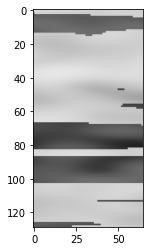

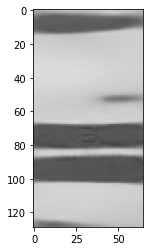

In [23]:
#my_x = fixed_x
#dimz=15
my_x = images
plt.figure()
indt = 14
vmin,vmax = 0.1,0.9
plt.imshow(my_x[indt,0,:,:], cmap='Greys', vmin=vmin,vmax=vmax)
imgtens = torch.Tensor(my_x)
recon_x,zen,mn,vari = model(imgtens.to(device))
xx = recon_x.cpu().detach().numpy()
plt.figure()
plt.imshow(xx[indt,0,:,:], cmap='Greys', vmin=vmin,vmax=vmax)

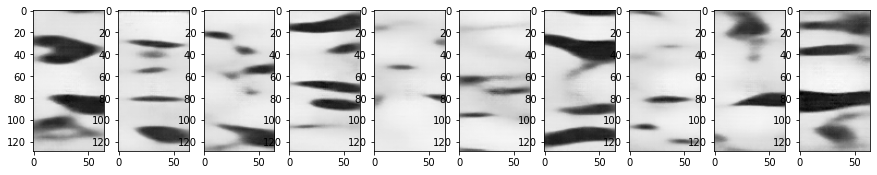

In [24]:
z_dim = dimz
z_new = 1.0*torch.randn(10,z_dim, dtype=torch.float, device=device)
x_new = model.decode(z_new)
#plt.figure()
#plt.imshow(x_new.cpu().detach().numpy()[0,0,:,:], cmap='Greys_r')
x_new = x_new.cpu().detach().numpy()

fig, ax = plt.subplots(1,10,figsize=(15,3))
ax = ax.ravel()
vmax,vmin = 1.0,0.0
vmax,vmin = np.max(x_new),np.min(x_new)
for i in range(len(ax)):
    ax[i].imshow(x_new[i,0,:,:],'Greys',vmin=vmin,vmax=vmax)

(array([ 170., 1116., 2069.,  910.,  475.,  254.,  228.,  213.,  187.,
         235.,  228.,  190.,  175.,  154.,  157.,  185.,  318.,  711.,
         387.,   23.]),
 array([0.28511882, 0.30716377, 0.32920873, 0.3512537 , 0.37329865,
        0.3953436 , 0.4173886 , 0.43943354, 0.4614785 , 0.48352346,
        0.5055684 , 0.5276134 , 0.54965836, 0.5717033 , 0.5937483 ,
        0.6157932 , 0.6378382 , 0.65988314, 0.6819281 , 0.70397305,
        0.726018  ], dtype=float32),
 <a list of 20 Patch objects>)

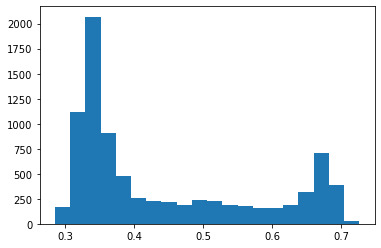

In [25]:
plt.hist(x_new[0,0,:,:].flatten(),bins=20)

In [26]:
#x_p = next(iter(dataset))
#x_p, _ = dataset[0:10]
#x_p.shape
#x_p = x_p.reshape((999,1,129,65))
#x_p = torch.Tensor(x_p.values)
#x_p = x_p.to(device)
#z_p = model.encode(x_p) 
#fixed_x, _ = next(iter(train_loader))
#fixed_x = .data.iloc[:999, 1:].values.astype(np.float32).reshape((999,1,129, 65))
test_x = torch.Tensor(fixed_x)
test_x = test_x.to(device)
test_x1 = torch.Tensor(images)
test_x1 = test_x1.to(device)
z_p, _, _ = model.encode(test_x)
z_p1, _, _ = model.encode(test_x1)

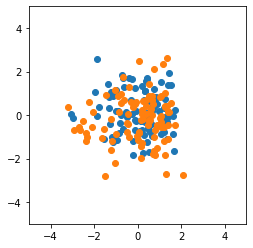

In [27]:
dim1 = 12
dim2 = 13
z_np = z_p.cpu().detach().numpy()
z_np1 = z_p1.cpu().detach().numpy()
plt.scatter(z_np[:,dim1],z_np[:,dim2])
plt.scatter(z_np1[:,dim1],z_np1[:,dim2])
plt.axis([-5, 5, -5, 5])
plt.gca().set_aspect('equal', adjustable='box')
#from pandas.plotting import scatter_matrix
#import pandas as pd
#df = pd.DataFrame(np.row_stack((z_np,z_np1)))
#scatter_matrix(df, alpha = 0.2, figsize = (10, 10), diagonal = 'hist')
#plt.show()

In [28]:
z_np.shape

(100, 40)

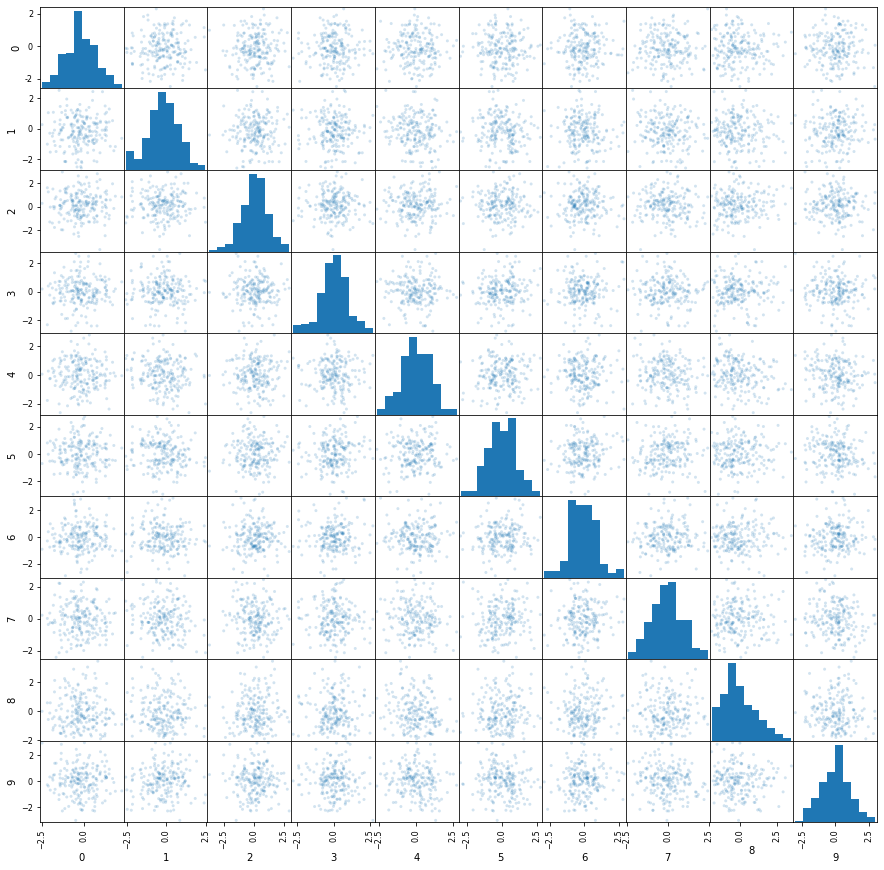

In [29]:
from pandas.plotting import scatter_matrix
import pandas as pd
plotdim = 10
df = pd.DataFrame(np.row_stack((z_np[:,:plotdim],z_np1[:,:plotdim])))
scatter_matrix(df, alpha = 0.2, figsize = (15, 15), diagonal = 'hist')
plt.show()

Text(0.5, 1.0, '$g_\\theta(\\mathbf{z}^{(2)})$')

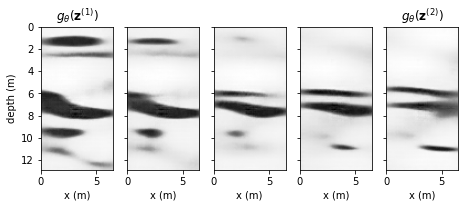

In [30]:
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _, _ = model.encode(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
#digits = [[] for _ in range(10)]
#for img_batch, label_batch in test_dataloader:
#    for i in range(img_batch.size(0)):
#        digits[label_batch[i]].append(img_batch[i:i+1])
#    if sum(len(d) for d in digits) >= 1000:
#        break;

z_new1 = 1.0*torch.randn(1,dimz, dtype=torch.float, device=device)
z_new2 = 1.0*torch.randn(1,dimz, dtype=torch.float, device=device)
img1 = model.decode(z_new1)#torch.Tensor(fixed_x[5:6,0:1,:,:])
img2 = model.decode(z_new2)#torch.Tensor(fixed_x[6:7,0:1,:,:])

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

#plt.rc('text', usetex=False)

fig, axs = plt.subplots(1,5, figsize=(7.48, 3))
fig.subplots_adjust(hspace = .5, wspace= 0.2)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), model, img1, img2)#digits[7][0], digits[1][0])
   
    inter_image = inter_image.clamp(0,1)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='Greys', origin='upper', extent=[0,6.5,12.9,0])
    #axs[ind].set_title('lambda='+str(round(l,2)))
    if ind > 0: axs[ind].set_yticklabels('')
    axs[ind].set_xlabel(r'x (m)')

axs[0].set_title(r'$g_\theta(\mathbf{z}^{(1)})$')
axs[0].set_ylabel(r'depth (m)')
axs[-1].set_title(r'$g_\theta(\mathbf{z}^{(2)})$')

In [26]:
fig.tight_layout()
fig.savefig('interpolation_lats.svg',dpi=300)

In [31]:
# save model state
torch.save(model.state_dict(), '/home/jorge/Documents/PhD_proj3/training/VAE100eps40_tl2ts2bis.pth')

In [32]:
# Setup trasversal latent plotting
tsteps = 6
tras_lat = np.linspace(-2.5,2.5,tsteps)
#z_init = 1.0*torch.randn([1, 20]).to(device)
z_init = 1.0*torch.zeros([1, dimz]).to(device)

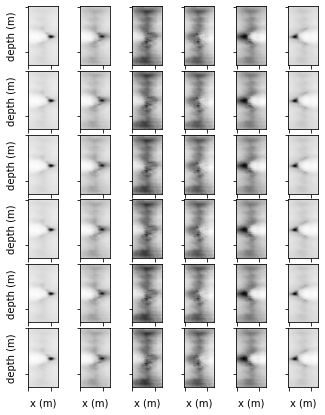

In [33]:
# Trasversal latent plotting
dim1 = 0
dim2 = 1
z_new = torch.clone(z_init)
fig, axs = plt.subplots(tsteps,tsteps, figsize=(5.51, 7))
fig.subplots_adjust(hspace = 0.1, wspace= 0.1)
for i in range(tsteps):
    z_new[0,dim1] = tras_lat[i]
    axs[i,0].set_ylabel('depth (m)')
    for j in range(tsteps):
        z_new[0,dim2] = tras_lat[j]
        x_new = model.decode(z_new)
        axs[i,j].imshow(x_new.cpu().detach().numpy()[0,0,:,:], cmap='Greys')
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticklabels([])
        if i==(tsteps-1): axs[i,j].set_xlabel('x (m)')

In [168]:
#fig.tight_layout()
fig.savefig('traverse_lats.svg',dpi=300)